In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'Data/SIR_Origin/*.csv'
dic_files = Load_files.load_files(path, -17, -15)
data = dic_files['서울']
data

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1167,2023-04-01,서울,3544282,25006,6383,5959761,0.258321,0.074782,0.000000
1168,2023-04-02,서울,3541881,25537,6383,5961631,0.088766,0.026980,0.000039
1169,2023-04-03,서울,3541039,25689,6384,5962320,0.376110,0.110631,0.000117
1170,2023-04-04,서울,3537451,26432,6387,5965162,0.341943,0.103019,0.000113


In [3]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 20
hidden_size = 16
num_layers = 2
batch_size = 32
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'Date', 'alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 7, batch_size, 'mtm')

model_LSTM_seq2seq = LSTM_encoder_decoder(input_size = input_size,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers, 
                                        dropout = dropout, 
                                        device = device).to(device)

model = model_LSTM_seq2seq

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([800, 60, 3])
torch.Size([800, 7, 1])
torch.Size([304, 60, 3])
torch.Size([304, 7, 1])


In [4]:
loss_list, model = Trainer.Many_to_Many(train_loader, 
                                        test_loader, 
                                        model, 
                                        criterion, 
                                        optimizer, 
                                        num_epochs, 
                                        patience,
                                        device)

epoch: 100 loss: 0.000683

 Early Stopping / epoch: 121 loss: 0.000680


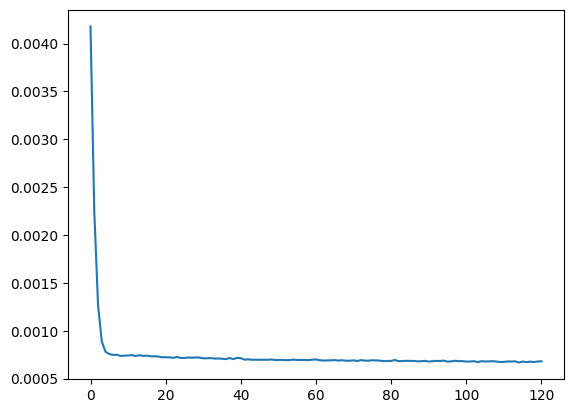

In [5]:
plt.plot(loss_list)

In [6]:
first_label_y, first_predicted = predict_mtm(model, df, x_ss, y_ms, 7, 0.5, device)

90.31605124473572


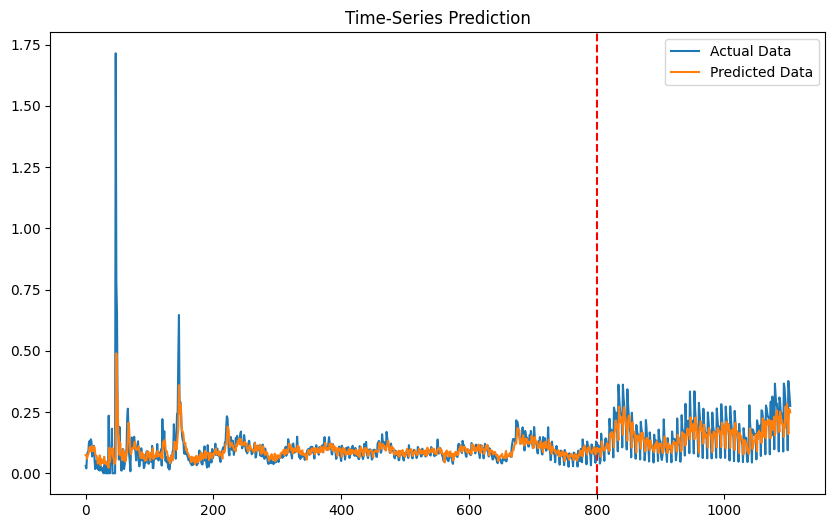

In [7]:
print(mape(first_label_y+1, first_predicted))
plotting(first_label_y, first_predicted)

In [8]:
data_predicted = data.copy()
data_predicted['predicted_alpha'] = 0
data_predicted.iloc[68:, -1] = first_predicted
data_predicted['predicted_Infected'] = data_predicted['Infected']
for i in range(801, len(data_predicted)):
    data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                  *(1-data_predicted.iloc[i-1, 7] - data_predicted.iloc[i-1, 8]
                                    +(data_predicted.iloc[i-1, 2]*data_predicted.iloc[i-1, 9]
                                      /data_predicted.iloc[0, 2])))
data_predicted

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma,predicted_alpha,predicted_Infected
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1167,2023-04-01,서울,3544282,25006,6383,5959761,0.258321,0.074782,0.000000,0.227682,1439.165555
1168,2023-04-02,서울,3541881,25537,6383,5961631,0.088766,0.026980,0.000039,0.159599,1453.336414
1169,2023-04-03,서울,3541039,25689,6384,5962320,0.376110,0.110631,0.000117,0.249695,1500.224587
1170,2023-04-04,서울,3537451,26432,6387,5965162,0.341943,0.103019,0.000113,0.261720,1473.187500


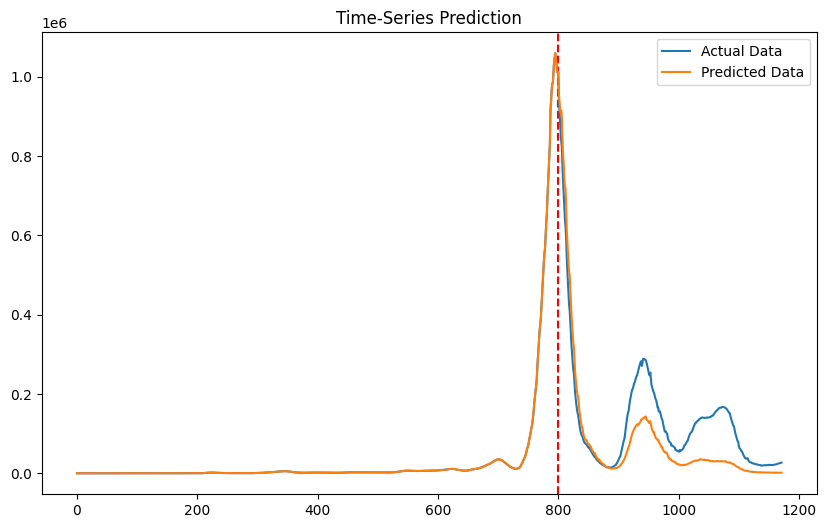

In [9]:
plotting(data_predicted['Infected'], data_predicted['predicted_Infected'])